In [97]:
import torch
import torchvision
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.utils as vutils
from timeit import default_timer as timer 
import os 
#get_ipython().run_line_magic('matplotlib', 'inline')

In [74]:
pwd

'C:\\Users\\deval\\OneDrive\\Desktop\\Parellel Machine Learning and AI\\Project'

In [75]:
import os
os.chdir(r'C:/Users/deval/OneDrive/Desktop/Parellel Machine Learning and AI/Project')

In [99]:
lr = 0.0002
max_epoch = 4
batch_size = 64
z_dim = 100
image_size = 64
g_conv_dim = 64
d_conv_dim = 64
log_step = 100
sample_step = 500
sample_num = 32
IMAGE_PATH = 'img_align_celeba'
SAMPLE_PATH = '../'
ngpu = 1
nc = 3
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
if not os.path.exists(SAMPLE_PATH):
    os.makedirs(SAMPLE_PATH)

In [100]:
class CelebFace(Dataset):
    def __init__(self, csv_file,img_dir, transform=None):
        self.img_dir = img_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        #print(len(self.annotations))
        return len(self.annotations)
  
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index,0])
        #img_name = self.img_path[index]
        img = Image.open(img_path)
        y_label = torch.tensor(int (self.annotations.iloc[index,1]))

        if self.transform:
            img = self.transform(img)

            return (img, y_label)

In [101]:
dataroot = "img_align_celeba"

In [102]:
dataset = CelebFace(csv_file='list_attr_celeba.csv',img_dir = IMAGE_PATH,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           transforms.Normalize([0.5], [0.5])]))
# Create the dataloader
train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

In [103]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [104]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input) 

In [105]:
G = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
G.apply(weights_init)

# Print the model
print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [106]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)  

In [107]:
D = Discriminator(image_size)
D.cuda()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [109]:
D = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
D.apply(weights_init)

# Print the model
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [110]:
criterion = nn.BCELoss().cuda()
optimizerD = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
real_label = 1.
fake_label = 0.

In [111]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [112]:
try:
    G.load_state_dict(torch.load('generator.pkl'))
    D.load_state_dict(torch.load('discriminator.pkl'))
    print("\n-------------model restored-------------\n")
except:
    print("\n-------------model not restored-------------\n")
    pass


-------------model not restored-------------



In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [114]:
step = 0

In [115]:
fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)

In [116]:
import numpy as np
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [117]:
iters = 0
img_list = []
G_losses = []
D_losses = []

In [119]:
main_time = timer()
for epoch in range(max_epoch):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):
        start = timer()
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, max_epoch, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
       
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == max_epoch-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
print("GPU time: ",timer()- main_time)

[0/4][0/3166]	Loss_D: 0.5269	Loss_G: 2.2075	D(x): 0.7158	D(G(z)): 0.1293 / 0.1394
[0/4][100/3166]	Loss_D: 0.5440	Loss_G: 4.0439	D(x): 0.9250	D(G(z)): 0.3168 / 0.0252
[0/4][200/3166]	Loss_D: 0.7675	Loss_G: 1.0673	D(x): 0.5501	D(G(z)): 0.0716 / 0.3969
[0/4][300/3166]	Loss_D: 1.6127	Loss_G: 7.6166	D(x): 0.9793	D(G(z)): 0.7388 / 0.0009
[0/4][400/3166]	Loss_D: 1.2907	Loss_G: 0.4428	D(x): 0.3472	D(G(z)): 0.0469 / 0.6765
[0/4][500/3166]	Loss_D: 0.8428	Loss_G: 4.7649	D(x): 0.9306	D(G(z)): 0.4792 / 0.0126
[0/4][600/3166]	Loss_D: 0.8961	Loss_G: 4.8266	D(x): 0.9131	D(G(z)): 0.5021 / 0.0113
[0/4][700/3166]	Loss_D: 1.0080	Loss_G: 4.2141	D(x): 0.6458	D(G(z)): 0.3077 / 0.0200
[0/4][800/3166]	Loss_D: 0.5123	Loss_G: 4.1360	D(x): 0.9067	D(G(z)): 0.3083 / 0.0259
[0/4][900/3166]	Loss_D: 0.4366	Loss_G: 2.6166	D(x): 0.8300	D(G(z)): 0.1915 / 0.0971
[0/4][1000/3166]	Loss_D: 0.7270	Loss_G: 3.4271	D(x): 0.8242	D(G(z)): 0.3494 / 0.0464
[0/4][1100/3166]	Loss_D: 2.4255	Loss_G: 7.7028	D(x): 0.9643	D(G(z)): 0.8512 /

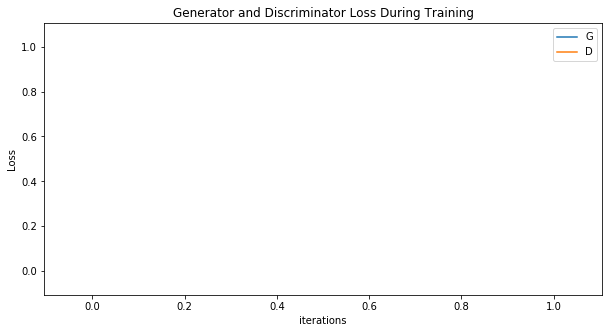

In [72]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
iters = 0

202599


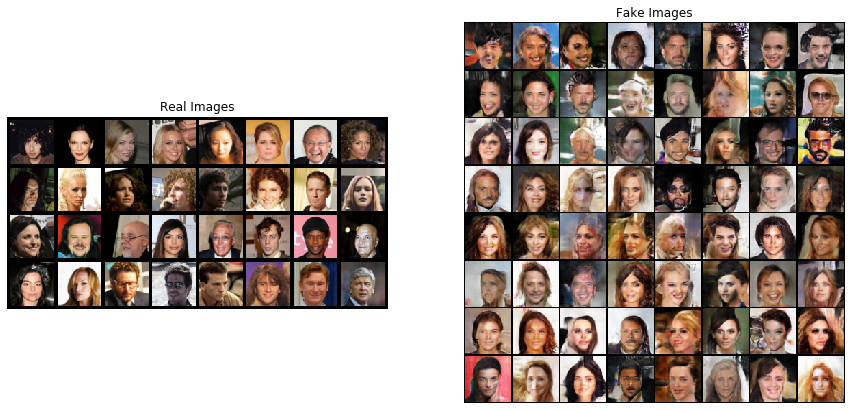

In [25]:
# **Real Images vs. Fake Images**
import torchvision.utils as vutils
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()